In [1]:
import pandas as pd
import os
import sys

# Load the library with the CountVectorizer method
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np

#import matplotlib.pyplot as plt and seaborn for visualisation
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

In [4]:
import re
import gensim
from gensim.utils import simple_preprocess
import spacy


In [7]:
imdb_df = pd.read_csv('IMDB Dataset.csv')
imdb_df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [8]:
# Remove punctuation
imdb_df['review'] = imdb_df['review'].apply(str).map(lambda x: re.sub('[,\.!?]', '', x))
# Convert the titles to lowercase
imdb_df['review'] = imdb_df['review'].apply(str).map(lambda x: x.lower())
# Print out the first rows of reviews
print(imdb_df['review'].apply(str).head()) 

0    one of the other reviewers has mentioned that ...
1    a wonderful little production <br /><br />the ...
2    i thought this was a wonderful way to spend ti...
3    basically there's a family where a little boy ...
4    petter mattei's "love in the time of money" is...
Name: review, dtype: object


In [10]:
def sent_to_words(sentences):
 for sentence in sentences:
   yield(gensim.utils.simple_preprocess(str(sentence), deacc=False)) #deacc=True removes punctuations

data = imdb_df['review'].tolist()
data = imdb_df['review'][0:500].tolist()
data_words = list(sent_to_words(data))
print('data_words[:1]', data_words[:1])

data_words[:1] [['one', 'of', 'the', 'other', 'reviewers', 'has', 'mentioned', 'that', 'after', 'watching', 'just', 'oz', 'episode', 'you', 'll', 'be', 'hooked', 'they', 'are', 'right', 'as', 'this', 'is', 'exactly', 'what', 'happened', 'with', 'me', 'br', 'br', 'the', 'first', 'thing', 'that', 'struck', 'me', 'about', 'oz', 'was', 'its', 'brutality', 'and', 'unflinching', 'scenes', 'of', 'violence', 'which', 'set', 'in', 'right', 'from', 'the', 'word', 'go', 'trust', 'me', 'this', 'is', 'not', 'show', 'for', 'the', 'faint', 'hearted', 'or', 'timid', 'this', 'show', 'pulls', 'no', 'punches', 'with', 'regards', 'to', 'drugs', 'sex', 'or', 'violence', 'its', 'is', 'hardcore', 'in', 'the', 'classic', 'use', 'of', 'the', 'word', 'br', 'br', 'it', 'is', 'called', 'oz', 'as', 'that', 'is', 'the', 'nickname', 'given', 'to', 'the', 'oswald', 'maximum', 'security', 'state', 'penitentary', 'it', 'focuses', 'mainly', 'on', 'emerald', 'city', 'an', 'experimental', 'section', 'of', 'the', 'prison',

In [11]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.

print('bigram',bigram)
print('bigram data',bigram[data_words])
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)
print('trigram',trigram)

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)
bigram_mod.save("bigram_mod")
trigram_mod.save("trigram_mod")
bigram_mod = gensim.models.Phrases.load("bigram_mod")
trigram_mod = gensim.models.Phrases.load("trigram_mod")

bigram Phrases<81954 vocab, min_count=5, threshold=100, max_vocab_size=40000000>
bigram data <gensim.interfaces.TransformedCorpus object at 0x7f9ef1ccf250>
trigram Phrases<82073 vocab, min_count=5, threshold=100, max_vocab_size=40000000>


In [12]:
for bigram in bigram_mod.phrasegrams.keys():
 print(bigram)
for trigram in trigram_mod.phrasegrams.keys():
 print(trigram) 

serial_killer
new_york
ve_seen
at_least
low_budget
year_old
reminds_me
ever_seen
high_school
special_effects
character_development
subject_matter
civil_war
cold_mountain
halfway_through
second_half
fast_forward
hong_kong
each_other
my_opinion
found_myself
years_ago
small_town
theme_song
rock_roll
star_trek
sit_through
sci_fi
huge_fan
jane_austen
anne_rice
new_world
pretty_woman
jackie_chan
throw_momma
gentleman_jim
ghost_stories
skeleton_dance
miss_dunne
bug_life
serial_killer
looking_forward
ve_seen
at_least
low_budget
year_old
reminds_me
ever_seen
high_school
special_effects
character_development
subject_matter
civil_war
cold_mountain
second_half
fast_forward
each_other
my_opinion
in_my_opinion
found_myself
years_ago
small_town
theme_song
rock_roll
sit_through
huge_fan
jane_austen
anne_rice
new_world
pretty_woman
jackie_chan
throw_momma
gentleman_jim
ghost_stories
skeleton_dance
miss_dunne
bug_life


In [13]:
from gensim.parsing.preprocessing import STOPWORDS
my_stop_words = STOPWORDS.union(set(['br']))

# Define functions for stopwords, bigrams, trigrams and lemmatisation
def remove_stopwords(texts):
 return [[word for word in simple_preprocess(str(doc)) if word not in
my_stop_words] for doc in texts]

In [15]:
def make_bigrams(texts):
 return [bigram_mod[doc] for doc in texts]
def make_trigrams(texts):
 return [trigram_mod[bigram_mod[doc]] for doc in texts]

# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)
# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

In [37]:
def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out  # Ensure this line is outside the for-loop

In [38]:
# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
nlp = spacy.load("en_core_web_sm", disable=['parser', 'ner'])
# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN',
'ADJ', 'VERB', 'ADV'])
print('data_lemmatized[:1]', data_lemmatized[:1])

data_lemmatized[:1] [['reviewer', 'mention', 'watch', 'episode', 'hook', 'right', 'exactly', 'happen', 'thing', 'strike', 'brutality', 'unflinche', 'scene', 'violence', 'set', 'right', 'word', 'trust', 'faint', 'hearted', 'timid', 'pull', 'punch', 'regard', 'drug', 'sex', 'violence', 'hardcore', 'classic', 'use', 'word', 'call', 'nickname', 'give', 'oswald', 'maximum', 'security', 'state', 'penitentary', 'focus', 'mainly', 'section', 'prison', 'cell', 'glass', 'front', 'face', 'inward', 'privacy', 'high', 'agenda', 'home', 'muslim', 'italian', 'irish', 'moreso', 'scuffle', 'death', 'stare', 'dodgy', 'dealing', 'shady', 'agreement', 'far', 'away', 'main', 'appeal', 'fact', 'go', 'show', 'forget', 'pretty', 'picture', 'paint', 'mainstream', 'audience', 'forget', 'charm', 'romanceoz', 'mess', 'episode', 'see', 'strike', 'nasty', 'surreal', 'ready', 'watch', 'develop', 'taste', 'get', 'accustom', 'high', 'level', 'graphic', 'violence', 'violence', 'injustice', 'crook', 'guard', 'sell', 'ni

In [39]:
from wordcloud import WordCloud

def getWordCloud(hashtags):
 # Read the whole text.
 text = ' '.join(hashtags)
 # Generate a word cloud image
 wordcloud = WordCloud().generate(text)
 # Display the generated image:
 # the matplotlib way:
 plt.imshow(wordcloud, interpolation='bilinear')
 plt.axis("off")
 # lower max_font_size
 wordcloud = WordCloud(max_font_size=40).generate(text)
 plt.figure()
 plt.imshow(wordcloud, interpolation="bilinear")
 plt.axis("off")
 plt.savefig('wordcloud_all.pdf', dpi=500)
 plt.show()

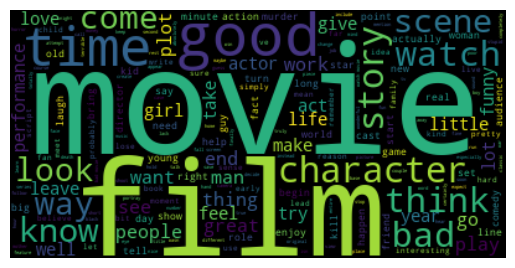

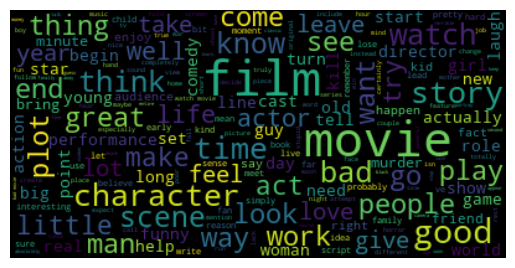

In [40]:
s = []
for l in data_lemmatized:
 t = ' '.join(l)
 s.append(t)
getWordCloud(s)

Sentiment analysis

In [52]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# Flatten the list of processed reviews
flat_data = [' '.join(doc) for doc in data_lemmatized]

# Initialize CountVectorizer
vectorizer = TfidfVectorizer(ngram_range=(1, 2))
X = vectorizer.fit_transform(flat_data)

# Limit X to 500 samples 
X = X[:500]

In [55]:
from sklearn.preprocessing import LabelEncoder

labelencoder = LabelEncoder()
y = labelencoder.fit_transform(imdb_df['sentiment'])
# Limit X to 500 samples 
y = y[:500]

In [56]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [58]:
from sklearn.linear_model import LogisticRegression

classifier = LogisticRegression()
classifier.fit(X_train, y_train)

LogisticRegression()

In [59]:
from sklearn.metrics import accuracy_score, classification_report

y_pred = classifier.predict(X_test)
print(f'Accuracy: {accuracy_score(y_test, y_pred)}')
print(classification_report(y_test, y_pred))

Accuracy: 0.55
              precision    recall  f1-score   support

           0       0.51      0.98      0.67        46
           1       0.91      0.19      0.31        54

    accuracy                           0.55       100
   macro avg       0.71      0.58      0.49       100
weighted avg       0.72      0.55      0.47       100



In [63]:
from sklearn import preprocessing

def predict_sentiment(review):
    review = flat_data(review)
    review_vec = vectorizer.transform([review])
    return 'Positive' if classifier.predict(review_vec) == 1 else 'Negative'

Text(113.9222222222222, 0.5, 'predicted label')

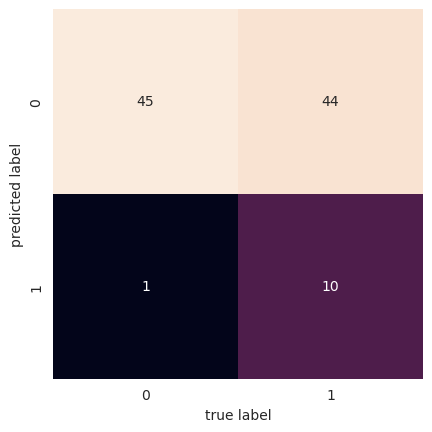

In [62]:
# Confusion matrix
from sklearn.metrics import confusion_matrix

mat = confusion_matrix(y_test, y_pred)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False)
plt.xlabel('true label')
plt.ylabel('predicted label')